In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

Make time series plot.

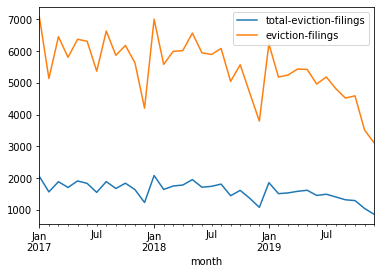

In [2]:
filename = 'nyc_processed_timeseries_2017_to_2019_20210225'
data = pd.read_csv('../data/processed/'+filename+'.csv')
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month')
data.plot()

Map of NYC cencus tract.

In [3]:
import folium

data = pd.read_csv('../data/processed/nyc_processed_2017_to_2019_20210225.csv',dtype={'census_tract_GEOID':'object'})
# print(data.columns)

nyc_geo = f'../data/geo/nyc_2010_tracts_formatted.geojson'
# import json
# with open(nyc_geo) as f:
#     gj = json.load(f)
# print(gj['features'][0])

col_name = 'ratio-to-mean-eviction-rate'
data[col_name] = data[col_name].replace(np.inf,np.NaN)
bins = list(data[col_name].quantile([0, 0.25, 0.5, 0.75, 1]))
nyc_map = folium.Map(location=[40.730610, -73.935242],zoom_start=10)

folium.Choropleth(
    geo_data=nyc_geo,
    name='choropleth',
    data=data,
    columns=['census_tract_GEOID', col_name],
    key_on='feature.properties.census_tract_GEOID', # Use 'feature', not 'features'. this seems to be a bug
    bins = bins,
    legend_name=col_name,
    fill_color='RdBu',
    fill_opacity=0.7,
    line_opacity=0.2
).add_to(nyc_map)

folium.LayerControl().add_to(nyc_map)

# nyc_map

# nyc_map.save('../../plots/nyc_map_'+col_name+'.html')

Time series of evictions

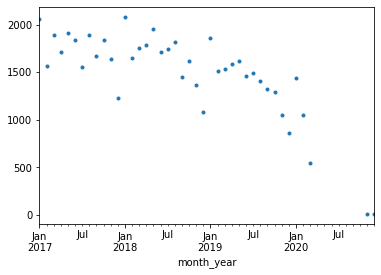

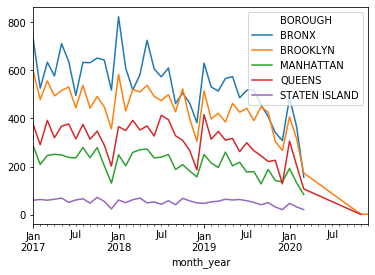

In [4]:
filename = 'nyc_evictions_geocoded' # nyc_evictions_present
data = pd.read_csv('../data/raw/'+filename +'.csv')
data['EXECUTED_DATE'] = pd.to_datetime(data['EXECUTED_DATE'])
data = data.drop(data['EXECUTED_DATE'].idxmax()) # one record that has an executed date in 2070
data['month_year'] = data['EXECUTED_DATE'].dt.to_period('M')
data.groupby('month_year').size().plot(style='.')
data.groupby(['month_year','BOROUGH']).size().unstack().plot()

Evictions of school districts.

In [6]:
import geopandas

sd = geopandas.read_file('../data/geo/nyc_school_districts.geojson')
data = pd.read_csv('../data/raw/nyc_evictions_geocoded.csv')
data[['lon','lat']] = data['lon_lat'].str.split(',',expand = True)
data = geopandas.GeoDataFrame(data,geometry=geopandas.points_from_xy(data.lon,
                                            data.lat, crs=sd.crs))
data = geopandas.sjoin(data,sd,op='within',how='left')
# data.columns

sd_data = data.groupby('school_dist').size().reset_index()
sd_data.columns = ['school_dist','total_evictions']

In [12]:
import plotly
import plotly.express as px

import json
with open('../data/geo/nyc_school_districts.geojson') as json_file:
    sdGeoJson = json.load(json_file)
# print(sdGeoJson['features'][0])

mean_lon, mean_lat = -73.93865, 40.788143

sd_map = px.choropleth_mapbox(sd_data, 
              geojson=sdGeoJson, 
              color="total_evictions",
              color_discrete_sequence = px.colors.qualitative.Dark24,
              locations="school_dist", 
              featureidkey="properties.school_dist",
              opacity=0.5,
              center={"lat": mean_lat ,"lon": mean_lon},
              mapbox_style="streets",
              height=1000,
              title = "Number of Evictions by School District",
              # margin={"r":0,"t":40,"l":0,"b":0,'pad':15},
              zoom=9)
#sd_map.update_layout(mapbox_accesstoken='pk.eyJ1IjoiZGdpbGxlbiIsImEiOiJjam85OGFvaXIxZXRlM2tubG8zY3E0OHh1In0.KkjAoFhjOOFjXAEuZ1IRog')   

# sd_map.show()
# sd_map.write_html('../../plots/nyc_school_districts.html')

In [2]:
!ls ../data/acs

data_dictionary.csv               nyc_acs5-2018_census.csv
hillsborough_acs5-2018_census.csv


In [5]:
data = pd.read_csv('../data/acs/nyc_acs5-2018_census.csv')